In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import learning_curve
import random
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.utils

Using TensorFlow backend.


# MNIST example: linear SVM and deep feed-forward ANN

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
# Auxiliary functions
def get_image(index, train):
    im = train.iloc[index]
    if 'label' in train:
        im = im.drop('label')
    im = im.values
    im = im.reshape(28, 28)
    return im

## 1. Data set

The MNIST data set contains 60000 labeled images depicting digits from 0 to 9. The data set used in this notebook is a subset of the original MNIST, containing 42000 samples. Some exemplary digits:

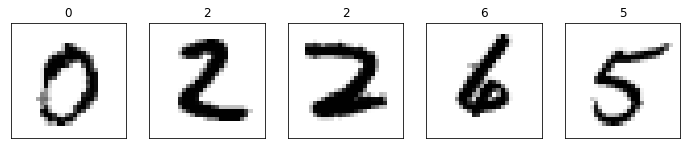

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(12, 5))
for i in range(len(axes)):
    n = random.randint(0, train.index.size)
    axes[i].imshow(get_image(n, train), cmap='gray_r')
    axes[i].set_title(train.iloc[n]['label'])
    axes[i].tick_params(bottom='off', labelbottom='off',
                        left='off', labelleft='off')

## 2. Linear SVM classifier

### 2.1 Training

Let's split data into training (80%) and validation (20%) sets:

In [6]:
def get_XY(train, start, end):
    X = train.iloc[start:end].drop('label', axis=1).values
    Y = train['label'].iloc[start:end].values
    return X, Y

# Training set
Xtrn, Ytrn = get_XY(train, 0, int(0.8 * 42000))

# Validation set
Xvld, Yvld = get_XY(train, int(0.8 * 42000) + 1, 42000)

print('Number of training samples: {}'.format(Xtrn.shape[0]))
print('Number of validation samples: {}'.format(Xvld.shape[0]))

Number of training samples: 33600
Number of validation samples: 8399


Now, let's test the model on different training data volumes:

In [7]:
time0 = time.time()
train_sizes, train_scores, valid_scores = learning_curve(
    svm.LinearSVC(), Xtrn, Ytrn, train_sizes=[100, 500, 1000, 5000, 10000, 25000], cv=5, n_jobs=3)
time1 = time.time()
print('Cross-validation finished in: {:.1f}s'.format(time1-time0))

Cross-validation finished in: 152.2s


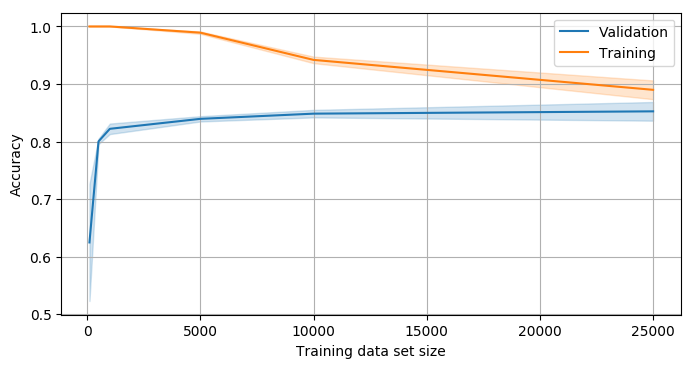

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100);
vld_mean = valid_scores.mean(axis=1)
vld_std  = valid_scores.std(axis=1)
trn_mean = train_scores.mean(axis=1)
trn_std  = train_scores.std(axis=1)
ax.plot(train_sizes, vld_mean, c='C0', label='Validation');
ax.fill_between(train_sizes, vld_mean - vld_std, vld_mean + vld_std, color='C0', alpha=0.2);
ax.plot(train_sizes, train_scores.mean(axis=1), c='C1', label='Training');
ax.fill_between(train_sizes, trn_mean - trn_std, trn_mean + trn_std, color='C1', alpha=0.2);
ax.legend();
ax.grid();
ax.set_xlabel('Training data set size');
ax.set_ylabel('Accuracy');

The training data set contains 37800 samples (80% of all data). The above figure shows that the model performance does not improve significantly on data sets with more than 10000 samples. It suggests that we have enough data in the training set. The average accuracy of the linear SVM is not very impressive, but at least its fast to train. 

Let's train the model on the 37800 training samples before moving to the validation data:

In [9]:
clf = svm.LinearSVC()
clf.fit(Xtrn, Ytrn)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### 2.2. Validation

The validation accuracy is equal to

In [10]:
svmacc = clf.score(Xvld, Yvld)
print('{:.2f}%,'.format(svmacc * 100.))

87.65%,


which is similar to the result depicted in the learning curve figure. Exemplary predictions together with the decision boundary:

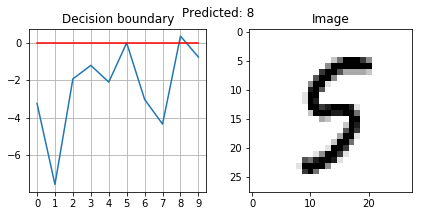

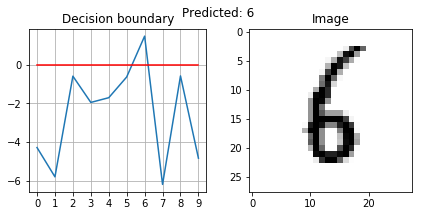

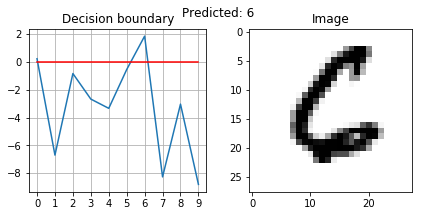

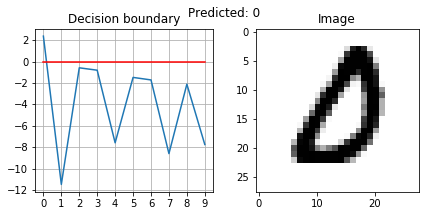

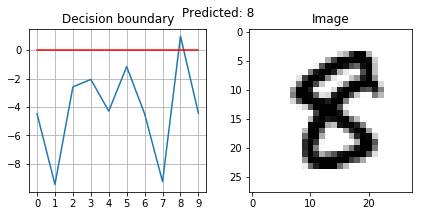

In [11]:
for sample in np.random.randint(0, Xvld.shape[0], 5):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    ax = axes[0]
    ax.set_title('Decision boundary')
    ax.plot(clf.decision_function(Xvld)[sample])
    ax.plot(np.zeros(10), color='r')
    ax.set_xticks(np.arange(0, 10, 1))
    ax.grid(True)
    ax = axes[1]
    ax.set_title('Image')
    ax.imshow(Xvld[sample].reshape((28,28)), cmap='gray_r')
    fig.suptitle('Predicted: {}'.format(clf.predict([Xvld[sample]])[0]))

## 3. Deep feed-forward ANN

### 3.1. Model

Let's test a (not very) deep ANN with 4 hidden layers, with 128, 64, 32 and 16 neurons each. All hidden neurons are defined with the rectifier activation function: $f(x) = \text{max}(0, x)$. The output layer is defined with the softmax function and contains 10 neurons - 1 neuron per possible outcome (0, 1, 2, ..., 9).

In [12]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dropout(0.15))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

### 3.2. Data preparation

Usually it's a good idea to normalize the data before training a model. In this case, however, the result shouldn't change much, because all pixels already contain values between 0 and 255 (the same range in all samples), and the rectifier function can yield any positive value. Anyway, 0-1 range looks nicer, so let's scale down the data:

In [13]:
# Normalize data (0..255 -> 0..1)
train = train.apply(lambda x: x / 255. if x.name != 'label' else x)

As a result, the digit '4' looks as follows (null-margins cropped):

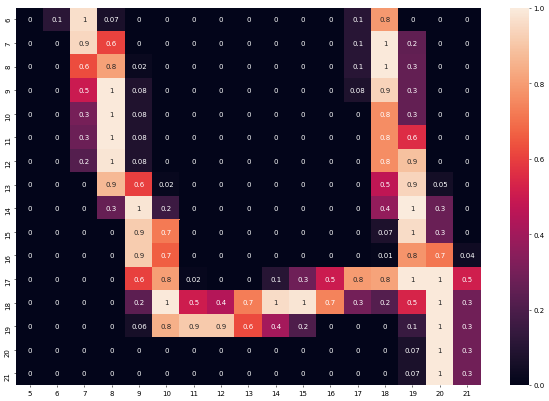

In [14]:
digit4 = pd.DataFrame(data=train.iloc[3].drop('label').values.reshape((28, 28)))
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=50)
sns.heatmap(digit4.loc[(digit4 != 0).any(), 5:21], annot=True, fmt='.1g', ax=ax);

In [15]:
# Prepare training data
sample = train.sample(frac=0.8)
x_train = sample.drop('label', axis=1).values
y_train = sample['label'].values
y_train = keras.utils.to_categorical(y_train, num_classes=10)

# Prepare test data
test = train.loc[[x for x in train.index if x not in sample.index]]
x_test = test.drop('label', axis=1).values
y_test = test['label'].values
y_test = keras.utils.to_categorical(y_test, num_classes=10)

### 3.3. Training

In [16]:
# Train ANN
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=30, batch_size=50, validation_split=0.05)

Train on 31920 samples, validate on 1680 samples
Epoch 1/30
31920/31920 [==============================] - 3s 93us/step - loss: 0.6197 - acc: 0.8102 - val_loss: 0.2290 - val_acc: 0.9345
Epoch 2/30
31920/31920 [==============================] - 3s 107us/step - loss: 0.2595 - acc: 0.9270 - val_loss: 0.1801 - val_acc: 0.9494
Epoch 3/30
31920/31920 [==============================] - 3s 88us/step - loss: 0.1984 - acc: 0.9461 - val_loss: 0.1467 - val_acc: 0.9595
Epoch 4/30
31920/31920 [==============================] - 3s 81us/step - loss: 0.1639 - acc: 0.9569 - val_loss: 0.1396 - val_acc: 0.9661
Epoch 5/30
31920/31920 [==============================] - 3s 80us/step - loss: 0.1452 - acc: 0.9613 - val_loss: 0.1421 - val_acc: 0.9661
Epoch 6/30
31920/31920 [==============================] - 3s 80us/step - loss: 0.1266 - acc: 0.9662 - val_loss: 0.1301 - val_acc: 0.9732
Epoch 7/30
31920/31920 [==============================] - 3s 80us/step - loss: 0.1151 - acc: 0.9686 - val_loss: 0.1061 - val_acc

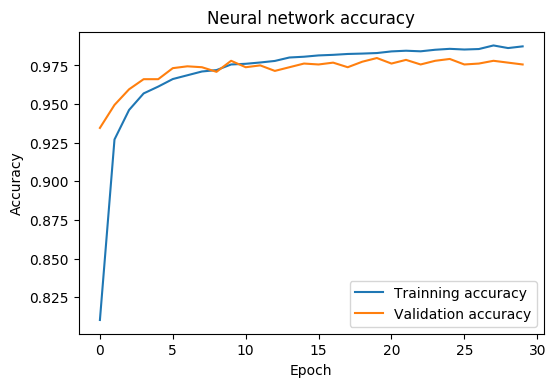

In [17]:
plt.plot(history.history['acc'], label='Trainning accuracy');
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.title('Neural network accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
fig = plt.gcf()
fig.set_dpi(100)

### 3.4. Validation

In [18]:
nnres = model.predict(Xvld)

In [19]:
# Calculate accuracy
nnpred = np.argmax(nnres, axis=1)
nnacc = 0.
for i in range(nnpred.size):
    if nnpred[i] == Yvld[i]:
        nnacc += 1
nnacc /= Yvld.size
print('Accuracy: {:.2f}%'.format(nnacc * 100.))

Accuracy: 99.04%


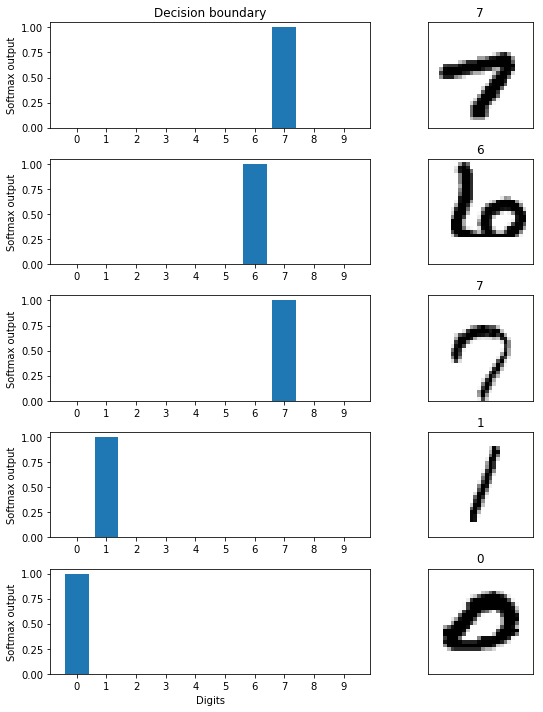

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(9, 10))
axes[0][0].set_title('Decision boundary')
axes[-1][0].set_xlabel('Digits')
i = 0
for s in np.random.randint(0, Xvld.shape[0], len(axes)):
    # Decision
    axes[i][0].bar(np.arange(10), nnres[s])
    axes[i][0].set_xticks(np.arange(10))
    axes[i][0].set_ylabel('Softmax output')
    
    # Image
    axes[i][1].imshow(Xvld[s].reshape((28, 28)), cmap='gray_r')
    axes[i][1].tick_params(bottom='off', labelbottom='off',
                           left='off', labelleft='off')
    axes[i][1].set_title(Yvld[s])
    
    # Increase axes count
    i += 1
    
fig.tight_layout()

## 4. Comparison between linear SVM and deep NN

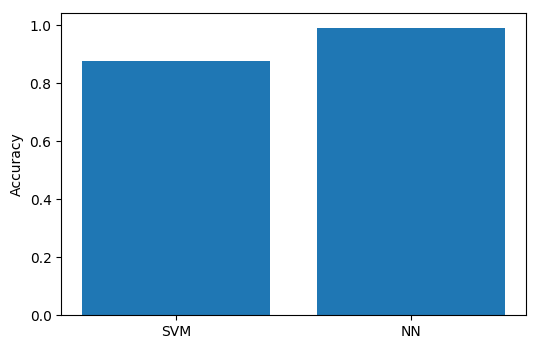

In [21]:
fig, ax = plt.subplots(1, 1, dpi=100);
ax.bar([0, 1], [svmacc, nnacc]);
ax.set_xticks([0, 1]);
ax.set_xticklabels(['SVM', 'NN']);
ax.set_ylabel('Accuracy');